## Trying to diagnose why VI has difficulty converging on this model 

In [7]:
import time

import numpy as np
import pymc3 as pm
from sklearn.datasets import load_diabetes, load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from theano import tensor as tt, shared
import matplotlib.pylab as plt

%matplotlib inline

In [30]:
def adding_intecept(X):
    """
    Adding a column for intercept
    :param X: features
    :return:
    """
    return np.c_[X, np.ones(X.shape[0])]


data = load_diabetes()  # load diabetes dataset
# data = load_boston() # load boston dataset
data["data"] = adding_intecept(data["data"])
X, X_test, y, y_test = train_test_split(
    data["data"], data["target"], test_size=0.25)

shared_X = shared(X)

# TODO : add hyper prior
# Define the model
with pm.Model() as regression_model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', 10.)

    w = pm.Normal("w", mu=0, sd=20, shape=X.shape[1])
    mu = tt.dot(w, shared_X.T)

    # Define likelihood
    likelihood = pm.Normal("y", mu=mu, sd=sigma, observed=y)

In [23]:
with regression_model:
    # Inference
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma_log__]
100%|██████████| 1500/1500 [00:03<00:00, 441.43it/s]


In [36]:
pm.sgd?

In [44]:
with regression_model:
    apprx = pm.fit(50000, method='advi', obj_n_mc=25,
                   obj_optimizer=pm.adagrad(learning_rate=50.))

Average Loss = 1,960.2: 100%|██████████| 50000/50000 [00:53<00:00, 943.00it/s]
Finished [100%]: Average Loss = 1,960.2


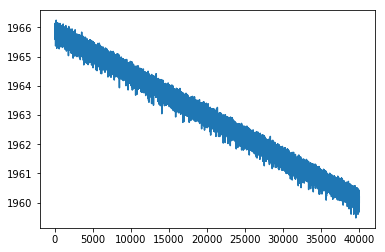

In [45]:
plt.plot(apprx.hist[10000:]);

In [50]:
apprx.groups[0].bij.rmap(apprx.params[0].eval())

{'sigma_log__': array(4.25433834),
 'w': array([ 12.20237742,   3.06760075,  47.48649899,  36.56623474,
         18.55803309,  12.2358095 , -24.81552255,  27.37072583,
         46.02615981,  25.88801179, 145.41653368])}

vanishing gradient problem for sigma? The parameters are on quite different scale.

In [48]:
trace_advi = apprx.sample(1000)

In [49]:
pm.summary(trace_advi)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w__0,12.151996,1.915088e+01,6.697213e-01,-24.482708,48.570463
w__1,2.631442,1.980425e+01,6.077516e-01,-38.472348,39.166968
w__2,46.802971,1.961405e+01,6.071395e-01,4.499628,83.218461
w__3,36.972119,1.871183e+01,4.802602e-01,1.146066,74.218429
w__4,18.024459,1.897042e+01,5.456657e-01,-22.856063,51.556063
w__5,12.497328,1.868825e+01,5.554777e-01,-24.843064,48.789377
w__6,-24.286686,1.965379e+01,6.201307e-01,-62.775260,14.398865
w__7,27.641623,2.004878e+01,6.531660e-01,-10.914295,66.756503
w__8,45.202409,1.835841e+01,5.816486e-01,11.823100,83.192858
w__9,25.620270,1.958274e+01,6.234862e-01,-15.045705,61.071236


In [5]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,15.270795,19.342731,0.238634,-21.538484,53.754845,6613.741213,0.999538
w__1,0.875702,20.023945,0.207138,-37.380027,42.944394,7522.904150,0.999885
w__2,48.227309,19.900793,0.246695,10.246399,87.250854,6723.850874,0.999588
w__3,37.418675,19.689594,0.223082,-1.676205,75.456478,6786.018649,0.999886
w__4,10.500697,19.399651,0.249792,-26.553114,49.223333,7010.250874,1.000234
w__5,6.457487,19.299314,0.242637,-29.586607,46.031805,7156.437871,0.999526
w__6,-32.367012,19.250458,0.241405,-71.343186,4.070938,6991.269886,0.999861
w__7,29.973261,19.832652,0.220519,-9.136929,69.518274,7068.279646,0.999788
w__8,47.509977,19.808073,0.240940,8.663488,85.196781,7425.167965,0.999692
w__9,30.295383,19.609746,0.228489,-9.390446,67.436823,6714.651145,1.000151


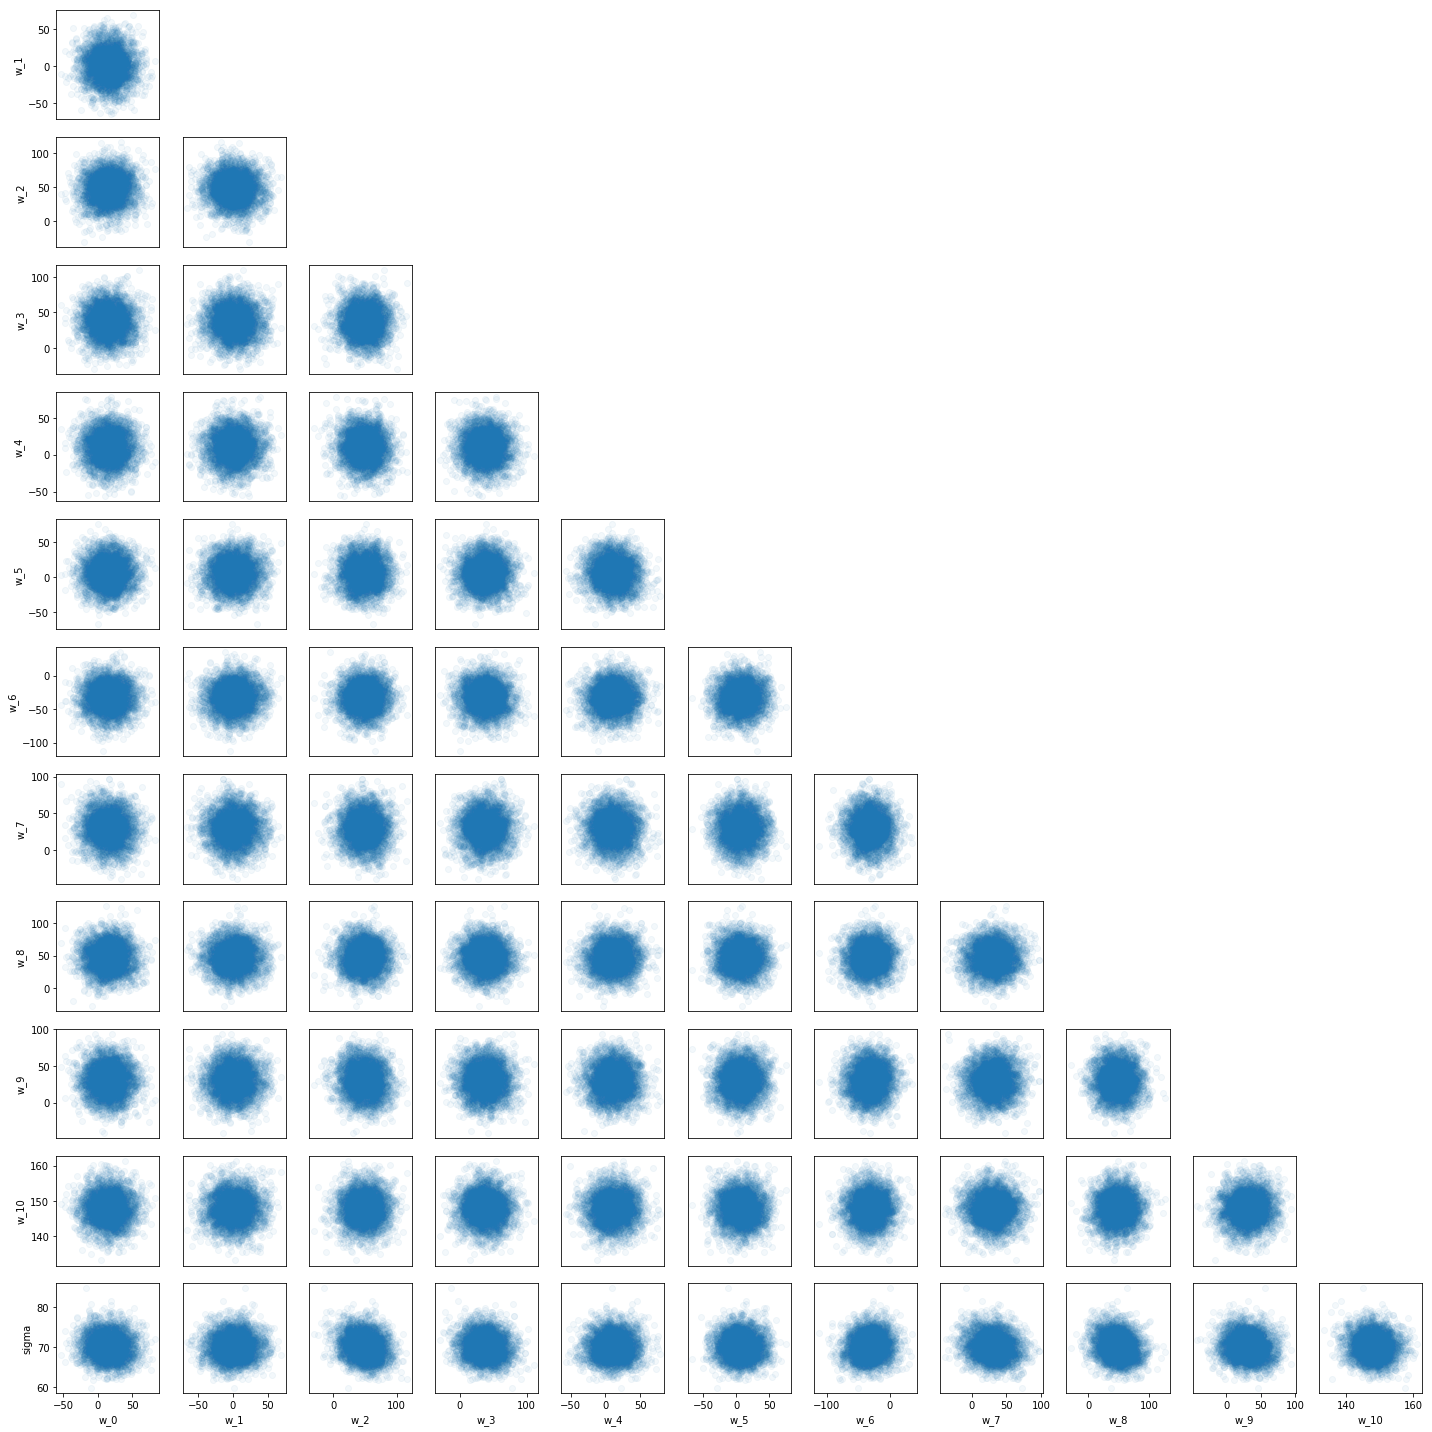

In [12]:
pm.pairplot(trace, alpha=.05);

In [2]:
shared_X.set_value(X_test)

# MCMC error
ppc = pm.sample_ppc(trace, model=regression_model, samples=50000)
pred_mcmc = ppc['y'].mean(axis=0)
mse_mcmc = mean_squared_error(y_test, pred_mcmc)
print("Inference : MCMC, wall time : %ims, mse: %f" %
      (time_taken_mcmc, mse_mcmc))

# ADVI error
ppc = pm.sample_ppc(apprx.sample(50000), model=regression_model, samples=50000)
pred_advi = ppc['y'].mean(axis=0)
mse_advi = mean_squared_error(y_test, pred_advi)
print("Inference : ADVI, wall time : %ims, mse: %f" %
      (time_taken_advi, mse_advi))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma_log__]
100%|██████████| 1500/1500 [00:03<00:00, 394.28it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '13709' (I am process '13710')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '13709' (I am process '13711')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '13710' (I am process '13711')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.

Inference : MCMC, wall time : 25945ms, mse: 5979.996439


100%|██████████| 50000/50000 [00:13<00:00, 3729.08it/s]

Inference : ADVI, wall time : 6166ms, mse: 27900.726342


## compare fitting